In [1]:
import os
import json
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
# Set seed
np.random.seed(42)

# set font to 12 and times new roman

plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"


In [2]:

os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"

Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\WattCast


In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

## Data imports

Grabbing all metrics from all runs

In [4]:
run = wandb.init(project='WattCast_2.0', name='results_synthesis', resume=True)


In [5]:
project_name = "Wattcast_2.0"

# Initialize your project
api = wandb.Api()
runs = api.runs(project_name)


name_id_dict = {}

for run_ in runs:
    l = run_.name.split('_')[:-1]
    l.insert(2, 'in')
    n = '_'.join(l)
    # remove the _ around in
    n = n.replace('_in_', 'in')
    name_id_dict[n] = run_.id

In [6]:

key_list = list(name_id_dict.keys())
for key in key_list:
    if key[0] not in ['1', '2', '3', '4', '5']:
        del name_id_dict[key]
        
dfs_sorted = {}
for name, id in name_id_dict.items():

    run_path = f'wattcast/WattCast/run-{id}-Errormetricsfor{name}:v0'
    artifact = run.use_artifact(f'{run_path}', type='run_table')
    artifact_dir = artifact.download()
    with open(os.path.join(artifact_dir, os.listdir(artifact_dir)[0])) as f:
        data = json.load(f)
    df_metrics = pd.DataFrame(data['data'], columns=data['columns'])
    df = df_metrics.sort_values(by=['model', 'season'])
    dfs_sorted[name] = df


CommError: Project wattcast/WattCast does not contain artifact: "run-1_county_Los_Angeles_60min-Errormetricsfor1_countyinLos_Angeles:v0"

## Results Exploration (Interactive Plots)

[![](https://raw.githubusercontent.com/wandb/assets/main/wandb-github-badge-gradient.svg)](https://wandb.ai/wattcast/WattCast)


In [ ]:


for name, df in dfs_sorted.items():

    # Define colors and shapes based on the season and model
    season2color = {'Summer': 'orange', 'Winter': 'blue'}
    color2season = {v: k for k, v in season2color.items()}
    model2shape = {
        'RandomForest': 'circle',
        'LightGBMModel': 'square',
        'XGBModel': 'diamond',
        'BlockRNNModel': 'cross',
        'NBEATSModel': 'triangle-up',
        'LinearRegressionModel': 'star'
    }
    shape2model = {v: k for k, v in model2shape.items()}




    # Map the colors and shapes to the DataFrame
    df['color'] = df['season'].map(season2color)
    df['shape'] = df['model'].map(model2shape)

    # Create the scatter plot
    fig = px.scatter(
        df,
        x='horizon_in_hours',
        y='rmse_skill_score',
        color='color',
        symbol='shape',
        #symbol_sequence= list(model2shape.values()),
        hover_data=['model'],
        title=f'RMSE Skill Score Compared to 24-Persistence over Forecast Horizon - {name}',
        labels={'rmse_skill_score': 'RMSE Skill Score', 'horizon_in_hours': 'Forecast Horizon (hours)'}

            
    )

    # set the x ticks and rename the legend
    fig.update_layout(
        xaxis=dict(
            tickmode='array',
            tickvals=[1, 4, 8, 24, 48],
        ),
        legend_title_text='Model',
    )

    for i in range(len(fig.data)):
        current_name = fig.data[i]['name']
        color, shape = current_name.split(', ')
        fig.data[i]['name'] = f'{shape2model[shape]} ({color2season[color]})'
        fig.data[i]['legendgroup'] = f'{shape2model[shape]}'

    # Update the figure size
    fig.update_layout(width=900, height=600)
    
    #fig.show()


## Paper Figures & Tables

### Plot 1: Skill Score vs Horizon for each model and season

In [ ]:

spatial_scale = 'county'

metric_of_interest = 'rmse_skill_score'

metric_dict = {'mape': 'Mean Absolute Percentage Error (MAPE)',
               'rmse': 'Root Mean Squared Error (RMSE)',
                'mae': 'Mean Absolute Error (MAE)',
                'smape': 'Symmetric Mean Absolute Percentage Error (SMAPE)',
                'rmse_skill_score': 'RMSE Skill Score',
                'r2_score': 'R2 Score',
                }


dfs_sorted_plot = dfs_sorted.copy()
keys = list(dfs_sorted_plot.keys())
for key in keys:
    if not spatial_scale in key:
        del dfs_sorted_plot[key]


# Define colors and shapes based on the season and model
season2color = {'Summer': 'orange', 'Winter': 'blue'}
color2season = {v: k for k, v in season2color.items()}
model2shape = {
    'RandomForest': 'o',
    'LightGBMModel': 's',
    'XGBModel': 'D',
    'BlockRNNModel': 'x',
    'NBEATSModel': '^',
    'LinearRegressionModel': '*'
}
shape2model = {v: k for k, v in model2shape.items()}

fig, axs = plt.subplots(1, len(dfs_sorted_plot), figsize=(5*(len(dfs_sorted_plot)),5), sharex=True, sharey=True)
axs = axs.ravel()

# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []

for i, ax in enumerate(axs):
    # Map the colors and shapes to the DataFrame
    name, df = list(dfs_sorted_plot.items())[i]
    df['color'] = df['season'].map(season2color)
    df['shape'] = df['model'].map(model2shape)

    for shape in set(df['shape']):
        for color in set(df.loc[df['shape'] == shape, 'color']):
            x = df.loc[(df['shape'] == shape) & (df['color'] == color), 'horizon_in_hours']
            y = df.loc[(df['shape'] == shape) & (df['color'] == color), metric_of_interest]
            label = f'{shape2model[shape]} ({color2season[color]})'
            scatter = ax.scatter(x, y, c=color, marker=shape, label=label)
            if label not in legend_labels:
                legend_handles.append(scatter)
                legend_labels.append(label)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])
    ax.set_xlabel('Forecast Horizon (hours)')

    # Set the y label
    if i == 0:
        ax.set_ylabel(f'{metric_dict[metric_of_interest]}')

    # Set the title for each subplot
    ax.set_title(f'{name.split("in")[-1].replace("_", " ")}')

    # Add grid for each subplot
    ax.grid(True)

    # Add a horizontal red dashed line at y = 0
    if metric_of_interest == 'rmse_skill_score':
        ax.axhline(y=0, color='red', linestyle='--')

# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [ ]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(os.getcwd(),'imgs','figures',f'{spatial_scale}{metric_of_interest}.{format}'), bbox_inches='tight')

### Plot 2: Side by side comparison of models for each season for a selected week

In [7]:
name_id_dict

{'1_countyinLos_Angeles': '1_county_Los_Angeles_60min'}

In [8]:
units_dict = {'county': 'GW', 'town': 'MW', 'village': 'kW', 'neighborhood': 'kW'}

run_to_visualize = '1_countyinLos_Angeles'
season = 'Winter'
algorithm = 'Light'


scale = run_to_visualize.split('_')[1].split('in')[0]

unit = units_dict[scale]

In [9]:
run = api.run(f"wattcast/Wattcast_2.0/{name_id_dict[run_to_visualize]}")
files = []
for file in run.files():
    if 'Side' in str(file) and season in str(file):
        files.append(file)

In [10]:
side_by_side_plots_dict = {}
for file in files:
    plot = file.download(replace=True)
    data = json.load(plot)
    plot_name = data['layout']['title']['text']
    side_by_side_plots_dict[plot_name] = data

In [11]:

def make_df_from_plot(plot):
    data = plot['data']
    df = pd.DataFrame()
    for i in range(len(data)):
        subdata = data[i]
        try:
            del subdata['line']
        except:
            pass
        df_line = pd.DataFrame(subdata)
        df_line.set_index('x', inplace=True)
        df_line.index.name = 'Datetime'
        col_name = data[i]['name']
        df_line = df_line.rename(columns={'y': col_name})
        df_line = df_line[[col_name]]
        df = pd.concat([df, df_line], axis=1)
    return df


df_all = pd.DataFrame()
for name, plot in side_by_side_plots_dict.items():
    df = make_df_from_plot(plot)
    df.columns = [col + ' ' + name for col in df.columns]
    df_all = pd.concat([df_all, df], axis=1)


In [12]:
df_gt = df_all.filter(like='Ground').iloc[:,:1]
df_gt.columns = ['Ground Truth']


# find the day with the highest peak
dt_highest_peak = pd.Timestamp(df_gt['Ground Truth'].idxmax()).date()
dt_start = dt_highest_peak - pd.Timedelta(days=2)
dt_end = dt_highest_peak + pd.Timedelta(days=2)


In [13]:

df_predictions = df_all.filter(like=algorithm)

df_predictions.columns = [col.split(': ')[1] + ' Ahead' for col in df_predictions.columns]
df_predictions.rename(columns={'1 Hours Ahead': '1 Hour Ahead'}, inplace=True)
df_predictions = df_predictions[['1 Hour Ahead', '4 Hours Ahead', '8 Hours Ahead', '24 Hours Ahead', '48 Hours Ahead']]

In [14]:
df_plot = pd.concat([df_predictions, df_gt], axis=1)
df_plot.index = pd.to_datetime(df_plot.index)
df_plot = df_plot.loc[dt_start:dt_end]


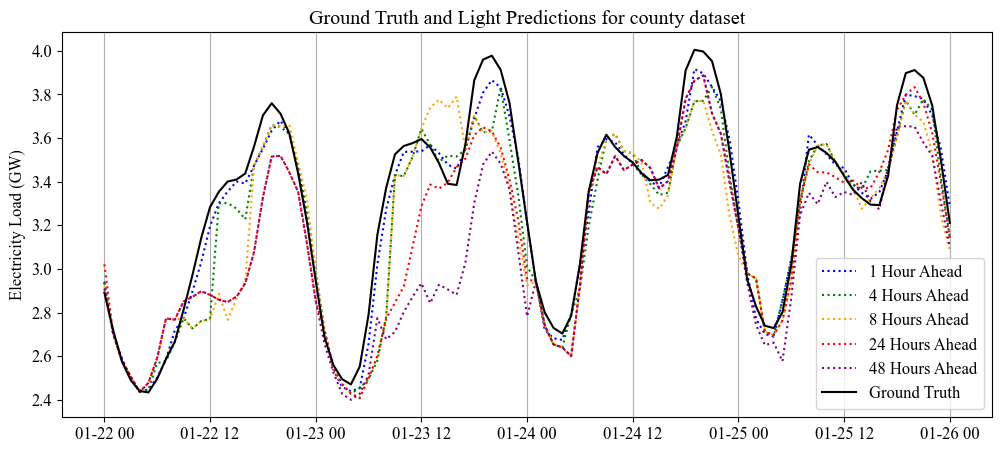

In [15]:
color_dict = {'Ground Truth': 'black',
                '1 Hour Ahead': 'blue',
                '4 Hours Ahead': 'green',
                '8 Hours Ahead': 'orange',
                '24 Hours Ahead': 'red',
                '48 Hours Ahead': 'purple'}



fig, ax = plt.subplots(figsize=(12,5))

for col in df_plot.columns:
    ax.plot(df_plot[col], label=col, color=color_dict[col], linestyle= 'solid' if col == 'Ground Truth' else ':')

ax.set_ylabel(f'Electricity Load ({unit})')
ax.set_title(f'Ground Truth and {algorithm} Predictions for {scale} dataset')

ax.grid(True, axis='x')
ax.legend()


### Plot 3: Comparing Spatial Scales

In [ ]:
df_metrics_all_scales = pd.DataFrame()

for scale, df in dfs_sorted.items():
    scale = scale.split('in')[0]
    df['scale'] = scale
    df_metrics_all_scales = df_metrics_all_scales.append(df)

# marginalize over the season
df_metrics_grouped = df_metrics_all_scales.groupby(['scale', 'model', 'horizon_in_hours']).mean()[[metric_of_interest]].reset_index()

# extract the model with the best performance for each scale and horizon
df_metrics_grouped = df_metrics_grouped.sort_values(by=['scale', metric_of_interest], ascending=False)
df_metrics_grouped = df_metrics_grouped.drop_duplicates(subset=['scale', 'horizon_in_hours'], keep='first')
df_metrics_grouped = df_metrics_grouped.sort_values(by=['scale', 'horizon_in_hours'])
df_metrics_grouped = df_metrics_grouped.reset_index(drop=True)


# Define colors and shapes based on the season and model
df = df_metrics_grouped
model2shape = {
    'RandomForest': 'o',
    'LightGBMModel': 's',
    'XGBModel': 'D',
    'BlockRNNModel': 'x',
    'NBEATSModel': '^',
    'LinearRegressionModel': '*'
}
shape2model = {v: k for k, v in model2shape.items()}

fig, ax = plt.subplots()

# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []


# Map the colors and shapes to the DataFrame
df['shape'] = df['model'].map(model2shape)

for shape in set(df['shape']):
    x = df.loc[(df['shape'] == shape), 'horizon_in_hours']
    y = df.loc[(df['shape'] == shape), 'scale']
    label = f'{shape2model[shape]}'
    scatter = ax.scatter(x, y, marker=shape, label=label)
    if label not in legend_labels:
        legend_handles.append(scatter)
        legend_labels.append(label)

# Set the x ticks and labels
ax.set_xticks([1, 4, 8, 24, 48])
ax.set_xlabel('Forecast Horizon (hours)')

# Set the y label
if i == 0:
    ax.set_ylabel(f'{metric_dict[metric_of_interest]}')

# Set the title for each subplot
ax.set_title(f'Best Model by {metric_dict[metric_of_interest]}')

# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.6, -0.25), ncol=2)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(os.getcwd(),'imgs','figures',f'across_scalees_{metric_of_interest}.{format}'), bbox_inches='tight')